## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

CHECKPOINT = {}
model_ckpt_best = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)
CHECKPOINT['model_ckpt_best'] = model_ckpt_best
model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=False)
CHECKPOINT['model_ckpt'] = model_ckpt
model_ckpt_wt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_weights_only=True)
CHECKPOINT['model_ckpt_wt'] = model_ckpt_wt

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for key in CHECKPOINT:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with CHECKPOINT = %s" % (key))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[CHECKPOINT[key]]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    # Load only weight
    if key == 'model_ckpt_wt':
        model.load_weights("./tmp.h5")
    # Load back
    else:
        model = keras.models.load_model("./tmp.h5")

    loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

    results[key] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc,
                             'loss_loadback': loss_loadback,
                             'acc_loadback': acc_loadback}




Experiment with CHECKPOINT = model_ckpt_best


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Bat

Epoch 38/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.7004 - acc: 0.7807 - val_loss: 1.5464 - val_acc: 0.4937
Epoch 39/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.6826 - acc: 0.7881 - val_loss: 1.5606 - val_acc: 0.4977
Epoch 40/50
50000/50000 [==============================] - 3s 56us/step - loss: 0.6643 - acc: 0.7954 - val_loss: 1.5749 - val_acc: 0.4980
Epoch 41/50
50000/50000 [==============================] - 3s 56us/step - loss: 0.6446 - acc: 0.8041 - val_loss: 1.5841 - val_acc: 0.4979
Epoch 42/50
50000/50000 [==============================] - 3s 56us/step - loss: 0.6289 - acc: 0.8099 - val_loss: 1.5969 - val_acc: 0.4923
Epoch 43/50
50000/50000 [==============================] - 3s 56us/step - loss: 0.6106 - acc: 0.8166 - val_loss: 1.6020 - val_acc: 0.4928
Epoch 44/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.5923 - acc: 0.8266 - val_loss: 1.6330 - val_acc: 0.4910
Epoch 45/50
50000/50000 [=========

50000/50000 [==============================] - 3s 56us/step - loss: 0.7372 - acc: 0.7654 - val_loss: 1.5334 - val_acc: 0.4889
Epoch 37/50
50000/50000 [==============================] - 3s 56us/step - loss: 0.7169 - acc: 0.7735 - val_loss: 1.5478 - val_acc: 0.4947
Epoch 38/50
50000/50000 [==============================] - 3s 56us/step - loss: 0.6996 - acc: 0.7801 - val_loss: 1.5648 - val_acc: 0.4898
Epoch 39/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.6812 - acc: 0.7877 - val_loss: 1.5653 - val_acc: 0.4929
Epoch 40/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.6618 - acc: 0.7955 - val_loss: 1.5626 - val_acc: 0.4922
Epoch 41/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.6398 - acc: 0.8058 - val_loss: 1.5845 - val_acc: 0.4940
Epoch 42/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.6256 - acc: 0.8101 - val_loss: 1.5897 - val_acc: 0.4970
Epoch 43/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 57us/step - loss: 0.7699 - acc: 0.7503 - val_loss: 1.5173 - val_acc: 0.4928
Epoch 35/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.7467 - acc: 0.7624 - val_loss: 1.5191 - val_acc: 0.4967
Epoch 36/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.7277 - acc: 0.7674 - val_loss: 1.5261 - val_acc: 0.4960
Epoch 37/50
50000/50000 [==============================] - 3s 56us/step - loss: 0.7092 - acc: 0.7765 - val_loss: 1.5419 - val_acc: 0.4953
Epoch 38/50
50000/50000 [==============================] - 3s 56us/step - loss: 0.6917 - acc: 0.7821 - val_loss: 1.5574 - val_acc: 0.4945
Epoch 39/50
50000/50000 [==============================] - 3s 55us/step - loss: 0.6742 - acc: 0.7903 - val_loss: 1.5689 - val_acc: 0.4906
Epoch 40/50
50000/50000 [==============================] - 3s 55us/step - loss: 0.6555 - acc: 0.7971 - val_loss: 1.5737 - val_acc: 0.4968
Epoch 41/50
50000/50000 [=====================

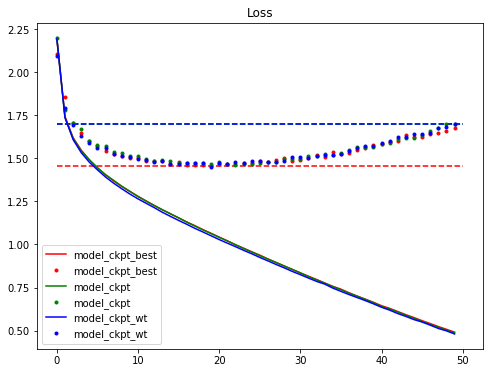

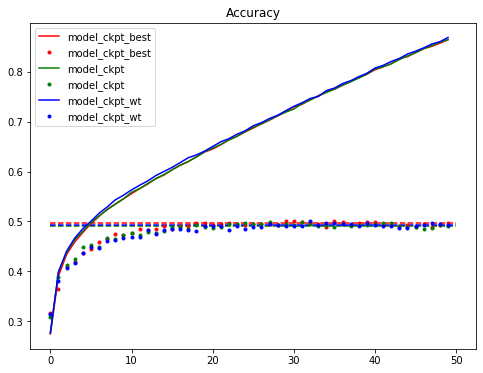

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '.', label=cond, color=color_bar[i])
    plt.hlines(y=results[cond]['loss_loadback'], xmin=0, xmax=len(results[cond]['train-loss']), color=color_bar[i], linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '.', label=cond, color=color_bar[i])
    plt.hlines(y=results[cond]['acc_loadback'], xmin=0, xmax=len(results[cond]['train-loss']), color=color_bar[i], linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()